In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/khairul-amin-cyber/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 5265, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 5265 (delta 36), reused 25 (delta 22), pack-reused 5207 (from 2)
Receiving objects: 100% (5265/5265), 1.61 GiB | 39.27 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (6369/6369), done.


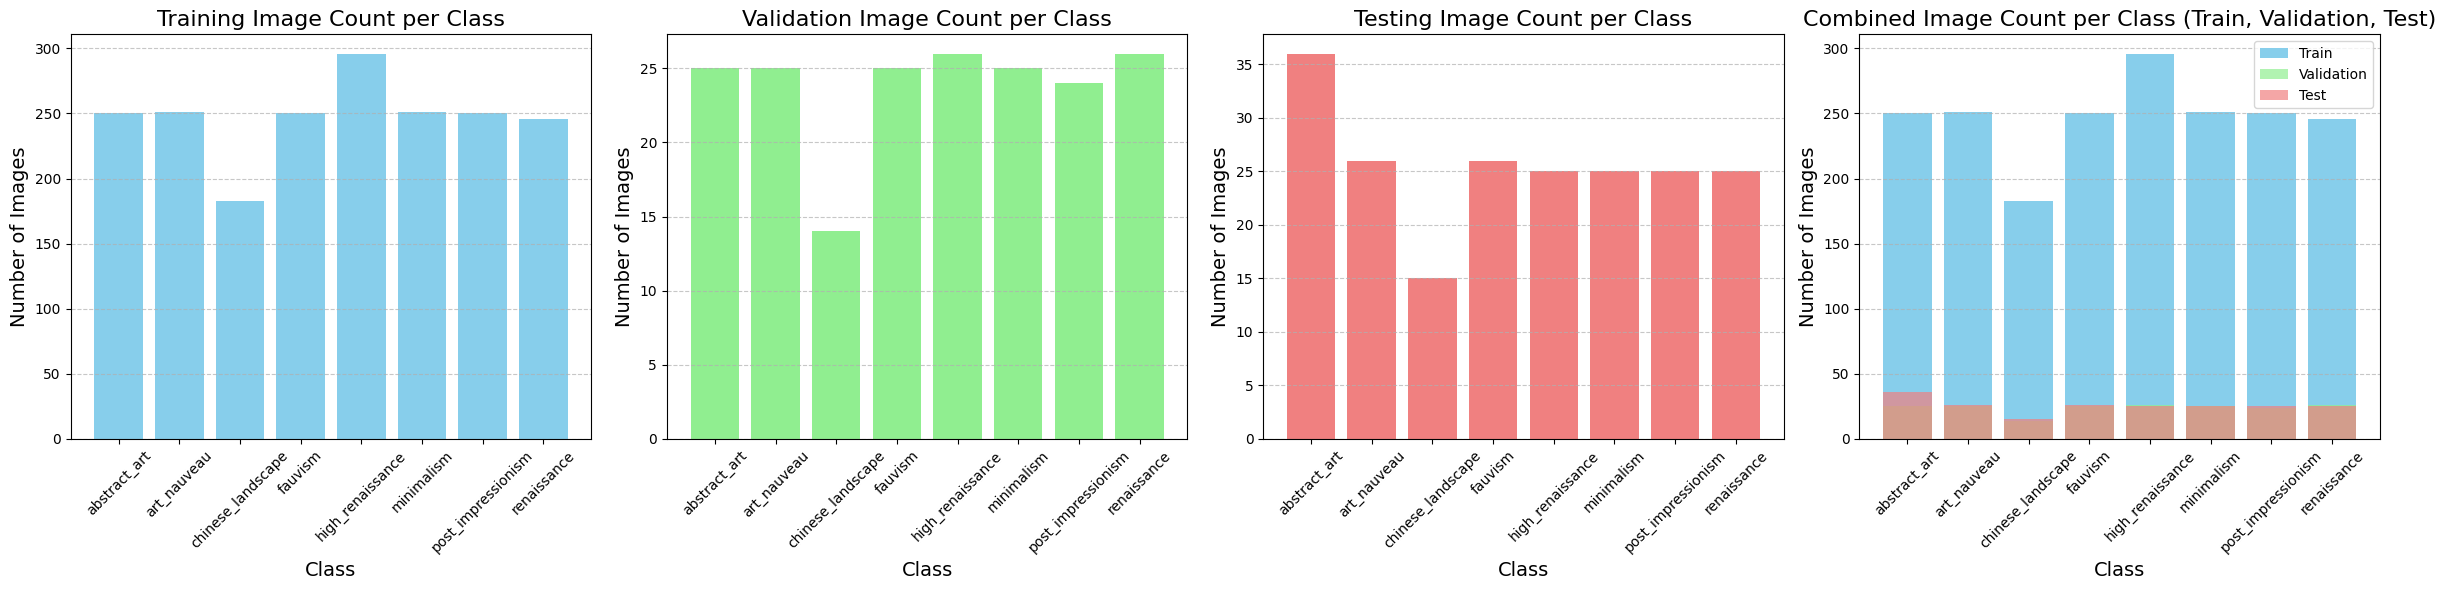

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# Mapping of sub-classes to main aesthetic classes (binary labels for each class)
class_to_main_class = {
    "abstract_art": [1, 0, 0, 0],  # Balance
    "art_nauveau": [1, 0, 0, 0],   # Balance
    "chinese_landscape": [0, 0, 0, 1],  # Texture & Brushwork
    "fauvism": [0, 1, 0, 0],  # Color Harmony
    "high_renaissance": [0, 0, 1, 0],  # Depth & Perspective
    "minimalism": [0, 0, 0, 1],  # Texture & Brushwork
    "post_impressionism": [0, 0, 1, 0],  # Depth & Perspective
    "renaissance": [0, 1, 0, 0]  # Color Harmony
}

# Custom Dataset to handle multi-label classification
class CustomAestheticDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = CustomAestheticDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomAestheticDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomAestheticDataset(root_dir=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]
Epoch 1/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.859]


Epoch 1/25 completed in 42.87 seconds.
Epoch Loss: 1.4146104272334807
Train Accuracy: 84.58%


Epoch 1/25 Validation Accuracy: 85.58%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.50batch/s, loss=0.677]


Epoch 2/25 completed in 41.24 seconds.
Epoch Loss: 0.5245819637371648
Train Accuracy: 95.29%


Epoch 2/25 Validation Accuracy: 86.64%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.68]


Epoch 3/25 completed in 41.76 seconds.
Epoch Loss: 0.21229395558757166
Train Accuracy: 98.34%


Epoch 3/25 Validation Accuracy: 87.43%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.087]


Epoch 4/25 completed in 41.96 seconds.
Epoch Loss: 0.15276096605004802
Train Accuracy: 98.88%


Epoch 4/25 Validation Accuracy: 86.90%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.703]


Epoch 5/25 completed in 41.94 seconds.
Epoch Loss: 0.16300146134510154
Train Accuracy: 98.55%


Epoch 5/25 Validation Accuracy: 85.71%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0229]


Epoch 6/25 completed in 42.57 seconds.
Epoch Loss: 0.18401491236422332
Train Accuracy: 98.49%


Epoch 6/25 Validation Accuracy: 86.77%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.501]


Epoch 7/25 completed in 42.04 seconds.
Epoch Loss: 0.14565931981609714
Train Accuracy: 98.57%


Epoch 7/25 Validation Accuracy: 85.98%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.615]


Epoch 8/25 completed in 42.25 seconds.
Epoch Loss: 0.1548145935239811
Train Accuracy: 98.50%


Epoch 8/25 Validation Accuracy: 84.52%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0524]


Epoch 9/25 completed in 42.49 seconds.
Epoch Loss: 0.11081839265722421
Train Accuracy: 99.18%


Epoch 9/25 Validation Accuracy: 86.90%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0268]


Epoch 10/25 completed in 41.90 seconds.
Epoch Loss: 0.06875258627077264
Train Accuracy: 99.44%


Epoch 10/25 Validation Accuracy: 87.30%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0371]


Epoch 11/25 completed in 42.78 seconds.
Epoch Loss: 0.061031729869183995
Train Accuracy: 99.52%


Epoch 11/25 Validation Accuracy: 86.24%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0133]


Epoch 12/25 completed in 42.06 seconds.
Epoch Loss: 0.03496723060661386
Train Accuracy: 99.73%


Epoch 12/25 Validation Accuracy: 86.24%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0612]


Epoch 13/25 completed in 42.26 seconds.
Epoch Loss: 0.11313657576007949
Train Accuracy: 99.02%


Epoch 13/25 Validation Accuracy: 86.38%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0781]


Epoch 14/25 completed in 42.52 seconds.
Epoch Loss: 0.11146115879678438
Train Accuracy: 99.20%


Epoch 14/25 Validation Accuracy: 86.24%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0752]


Epoch 15/25 completed in 41.99 seconds.
Epoch Loss: 0.08031588499133865
Train Accuracy: 99.42%


Epoch 15/25 Validation Accuracy: 85.98%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.166]


Epoch 16/25 completed in 42.09 seconds.
Epoch Loss: 0.060434521215351956
Train Accuracy: 99.51%


Epoch 16/25 Validation Accuracy: 85.45%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.053]


Epoch 17/25 completed in 42.61 seconds.
Epoch Loss: 0.07774122572135961
Train Accuracy: 99.32%


Epoch 17/25 Validation Accuracy: 86.38%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0599]


Epoch 18/25 completed in 41.93 seconds.
Epoch Loss: 0.15652942163644418
Train Accuracy: 98.72%


Epoch 18/25 Validation Accuracy: 88.62%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0119]


Epoch 19/25 completed in 42.18 seconds.
Epoch Loss: 0.03776908431938218
Train Accuracy: 99.75%


Epoch 19/25 Validation Accuracy: 86.38%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0295]


Epoch 20/25 completed in 42.50 seconds.
Epoch Loss: 0.0300624750164007
Train Accuracy: 99.73%


Epoch 20/25 Validation Accuracy: 87.30%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0481]


Epoch 21/25 completed in 41.85 seconds.
Epoch Loss: 0.023065243855178837
Train Accuracy: 99.86%


Epoch 21/25 Validation Accuracy: 87.43%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.00868]


Epoch 22/25 completed in 42.64 seconds.
Epoch Loss: 0.03533354895039191
Train Accuracy: 99.81%


Epoch 22/25 Validation Accuracy: 87.04%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.306]


Epoch 23/25 completed in 41.96 seconds.
Epoch Loss: 0.14833900758399507
Train Accuracy: 98.91%


Epoch 23/25 Validation Accuracy: 86.11%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00907]


Epoch 24/25 completed in 41.90 seconds.
Epoch Loss: 0.0851264220977863
Train Accuracy: 99.20%


Epoch 24/25 Validation Accuracy: 86.90%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0333]


Epoch 25/25 completed in 42.53 seconds.
Epoch Loss: 0.056794196349425966
Train Accuracy: 99.49%


Epoch 25/25 Validation Accuracy: 87.57%

Total Training Time: 1132.75 seconds (18.88 minutes)


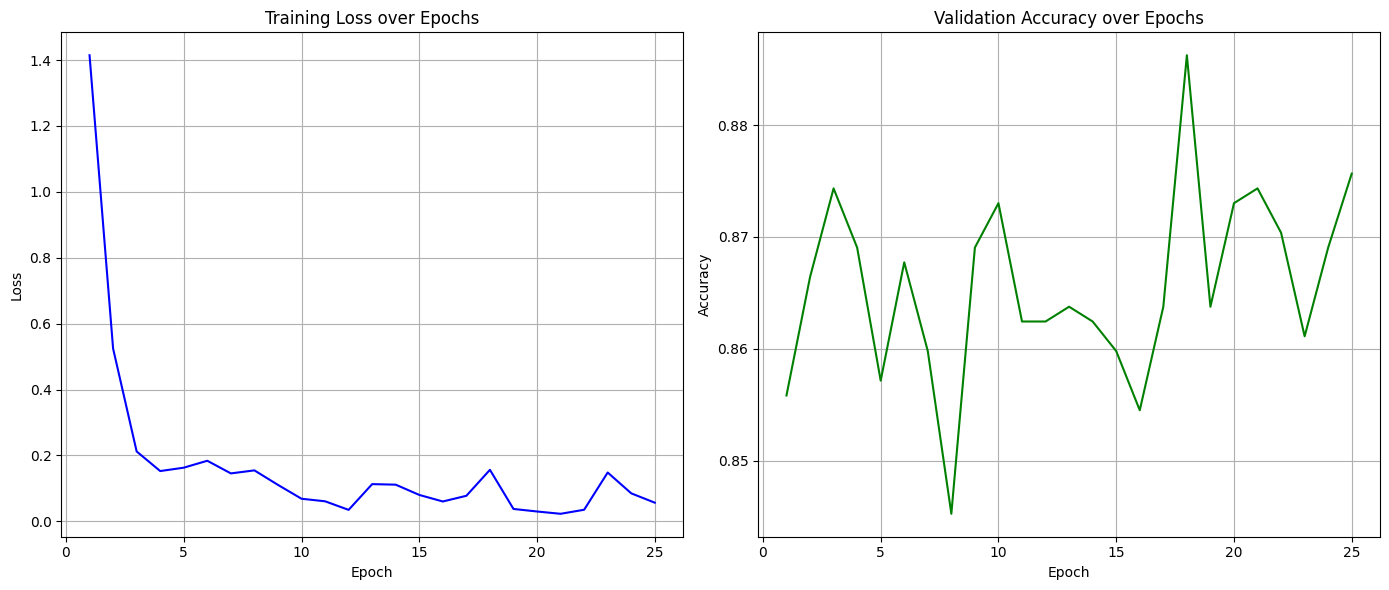

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import os
import matplotlib.pyplot as plt

# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Define model based on ResNet50 with custom heads for the 4 aesthetic classes
class AestheticModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork


# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet50_model = AestheticModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(resNet50_model.parameters(), lr=1e-4)

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    resNet50_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Plotting the Loss and Accuracy curves
plt.figure(figsize=(14, 6))

# Plot Training Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


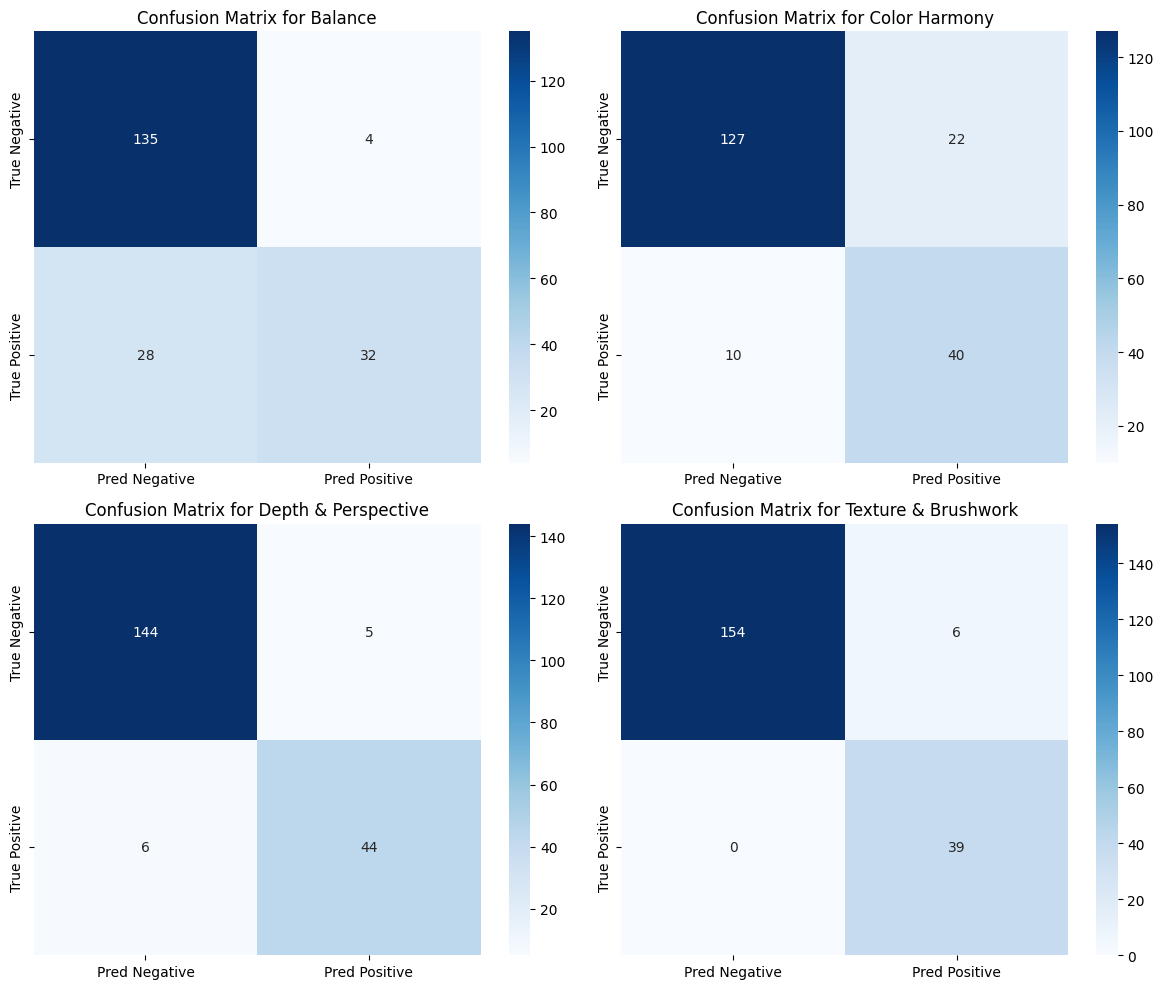

Test Accuracy: 89.82%
Precision: 76.63%
Recall: 77.89%
F1-Score: 77.05%


In [7]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
resNet50_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 90.1MB/s]
Epoch 1/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=1.39]


Epoch 1/25 completed in 54.59 seconds.
Epoch Loss: 1.364165980969706
Train Accuracy: 84.61%


Epoch 1/25 Validation Accuracy: 86.11%


Epoch 2/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.914]


Epoch 2/25 completed in 54.47 seconds.
Epoch Loss: 0.5638922647603096
Train Accuracy: 94.90%


Epoch 2/25 Validation Accuracy: 86.90%


Epoch 3/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.464]


Epoch 3/25 completed in 54.98 seconds.
Epoch Loss: 0.2808681712636063
Train Accuracy: 97.41%


Epoch 3/25 Validation Accuracy: 87.96%


Epoch 4/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.223]


Epoch 4/25 completed in 54.57 seconds.
Epoch Loss: 0.1851308811455965
Train Accuracy: 98.52%


Epoch 4/25 Validation Accuracy: 87.70%


Epoch 5/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.865]


Epoch 5/25 completed in 54.49 seconds.
Epoch Loss: 0.24087912949823564
Train Accuracy: 97.79%


Epoch 5/25 Validation Accuracy: 87.17%


Epoch 6/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.198]


Epoch 6/25 completed in 54.72 seconds.
Epoch Loss: 0.16687449401304608
Train Accuracy: 98.53%


Epoch 6/25 Validation Accuracy: 87.70%


Epoch 7/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0548]


Epoch 7/25 completed in 54.46 seconds.
Epoch Loss: 0.13325350852532974
Train Accuracy: 98.91%


Epoch 7/25 Validation Accuracy: 86.38%


Epoch 8/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.105]


Epoch 8/25 completed in 54.55 seconds.
Epoch Loss: 0.15451209114924555
Train Accuracy: 98.58%


Epoch 8/25 Validation Accuracy: 89.15%


Epoch 9/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0187]


Epoch 9/25 completed in 54.64 seconds.
Epoch Loss: 0.0799305583650787
Train Accuracy: 99.43%


Epoch 9/25 Validation Accuracy: 86.38%


Epoch 10/25 Training: 100%|██████████| 62/62 [00:53<00:00,  1.15batch/s, loss=0.0192]


Epoch 10/25 completed in 53.96 seconds.
Epoch Loss: 0.04310519608008044
Train Accuracy: 99.71%


Epoch 10/25 Validation Accuracy: 87.57%


Epoch 11/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.15batch/s, loss=0.00477]


Epoch 11/25 completed in 54.04 seconds.
Epoch Loss: 0.08943505359873656
Train Accuracy: 99.10%


Epoch 11/25 Validation Accuracy: 86.90%


Epoch 12/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00428]


Epoch 12/25 completed in 54.49 seconds.
Epoch Loss: 0.07431354756737428
Train Accuracy: 99.20%


Epoch 12/25 Validation Accuracy: 88.10%


Epoch 13/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0444]


Epoch 13/25 completed in 54.18 seconds.
Epoch Loss: 0.05103900983569122
Train Accuracy: 99.52%


Epoch 13/25 Validation Accuracy: 89.29%


Epoch 14/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00357]


Epoch 14/25 completed in 54.19 seconds.
Epoch Loss: 0.0913617454108692
Train Accuracy: 99.25%


Epoch 14/25 Validation Accuracy: 87.17%


Epoch 15/25 Training: 100%|██████████| 62/62 [00:53<00:00,  1.15batch/s, loss=1.7]


Epoch 15/25 completed in 53.95 seconds.
Epoch Loss: 0.09469434643735088
Train Accuracy: 99.47%


Epoch 15/25 Validation Accuracy: 88.36%


Epoch 16/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.00249]


Epoch 16/25 completed in 54.52 seconds.
Epoch Loss: 0.04286073542185007
Train Accuracy: 99.61%


Epoch 16/25 Validation Accuracy: 89.15%


Epoch 17/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.402]


Epoch 17/25 completed in 54.74 seconds.
Epoch Loss: 0.02195486064339357
Train Accuracy: 99.87%


Epoch 17/25 Validation Accuracy: 89.29%


Epoch 18/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.002]


Epoch 18/25 completed in 54.64 seconds.
Epoch Loss: 0.015180275629034205
Train Accuracy: 99.89%


Epoch 18/25 Validation Accuracy: 88.76%


Epoch 19/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0106]


Epoch 19/25 completed in 54.79 seconds.
Epoch Loss: 0.011875580008622379
Train Accuracy: 99.96%


Epoch 19/25 Validation Accuracy: 89.15%


Epoch 20/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.0291]


Epoch 20/25 completed in 54.60 seconds.
Epoch Loss: 0.006628147132071336
Train Accuracy: 99.96%


Epoch 20/25 Validation Accuracy: 88.10%


Epoch 21/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.000644]


Epoch 21/25 completed in 54.41 seconds.
Epoch Loss: 0.005835227532623967
Train Accuracy: 99.96%


Epoch 21/25 Validation Accuracy: 88.89%


Epoch 22/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.14batch/s, loss=0.126]


Epoch 22/25 completed in 54.34 seconds.
Epoch Loss: 0.005448028632541067
Train Accuracy: 99.99%


Epoch 22/25 Validation Accuracy: 89.42%


Epoch 23/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.0054]


Epoch 23/25 completed in 54.73 seconds.
Epoch Loss: 0.012725756423371364
Train Accuracy: 99.95%


Epoch 23/25 Validation Accuracy: 89.81%


Epoch 24/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.000692]


Epoch 24/25 completed in 54.91 seconds.
Epoch Loss: 0.004971459289194054
Train Accuracy: 99.96%


Epoch 24/25 Validation Accuracy: 87.04%


Epoch 25/25 Training: 100%|██████████| 62/62 [00:54<00:00,  1.13batch/s, loss=0.00362]


Epoch 25/25 completed in 54.73 seconds.
Epoch Loss: 0.0058105649204076
Train Accuracy: 99.96%


Epoch 25/25 Validation Accuracy: 87.96%

Total Training Time: 1450.36 seconds (24.17 minutes)
Test Accuracy: 89.45%


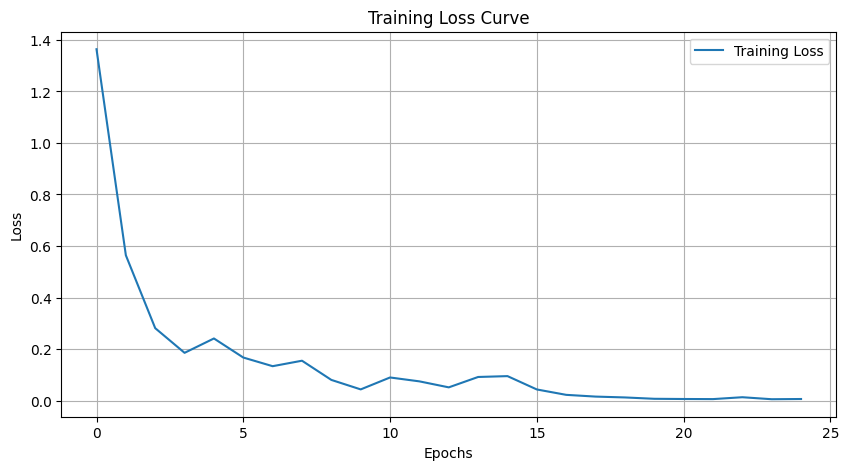

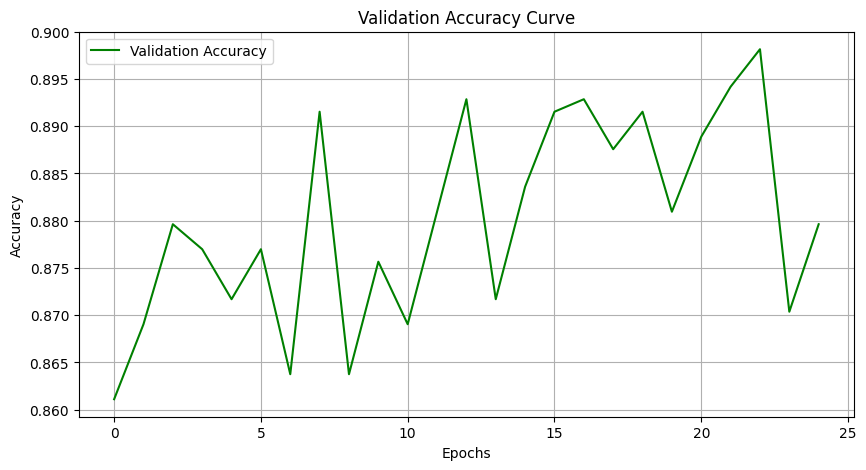

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # For ViT and other models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time
from tqdm import tqdm
from PIL import Image
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

class AestheticModelWithResNet101(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True)

        # Get the in_features from ResNet101's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork

# Initialize model, loss function, and optimizer
resNet101_model = AestheticModelWithResNet101(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.AdamW(resNet101_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (reduce learning rate when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Lists to store loss and validation accuracy for plotting
train_losses = []
val_accuracies = []

# Training loop with progress bar and time tracking
num_epochs = 25
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    resNet101_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update accuracy
            predictions = torch.cat([
                torch.sigmoid(balance),
                torch.sigmoid(color_harmony),
                torch.sigmoid(depth_perspective),
                torch.sigmoid(texture_brushwork)
            ], dim=1)

            # Binarize predictions (thresholding at 0.5)
            predicted_labels = (predictions > 0.5).float()

            # Compare predicted labels with the ground truth labels
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0) * labels.size(1)  # Total labels for all 4 categories

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    if total_train > 0:
        train_accuracy = correct_train / total_train  # Ensure division by non-zero total_train
        print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    else:
        print("Warning: Total train samples are zero.")

    train_losses.append(running_loss / len(train_loader))  # Store the train loss for each epoch

    # Validation phase
    resNet101_model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct_val += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct_val += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total_val += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Step the learning rate scheduler
    scheduler.step(running_loss)

# Total time for training
total_training_time = time.time() - start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds ({(total_training_time / 60):.2f} minutes)")

# Test Accuracy Evaluation
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

        # Convert logits to probabilities
        predictions = torch.cat([
            torch.sigmoid(balance),
            torch.sigmoid(color_harmony),
            torch.sigmoid(depth_perspective),
            torch.sigmoid(texture_brushwork)
        ], dim=1)

        # Binarize predictions (threshold = 0.5)
        predicted_labels = (predictions > 0.5).float()

        # Compute accuracy
        correct_test += (predicted_labels == labels).sum().item()
        total_test += labels.numel()

# Compute final test accuracy
test_accuracy = correct_test / total_test * 100

# Display results
print(f"Test Accuracy: {test_accuracy:.2f}%")

# --- Now plotting the loss and accuracy curves ---
# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plotting the validation accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


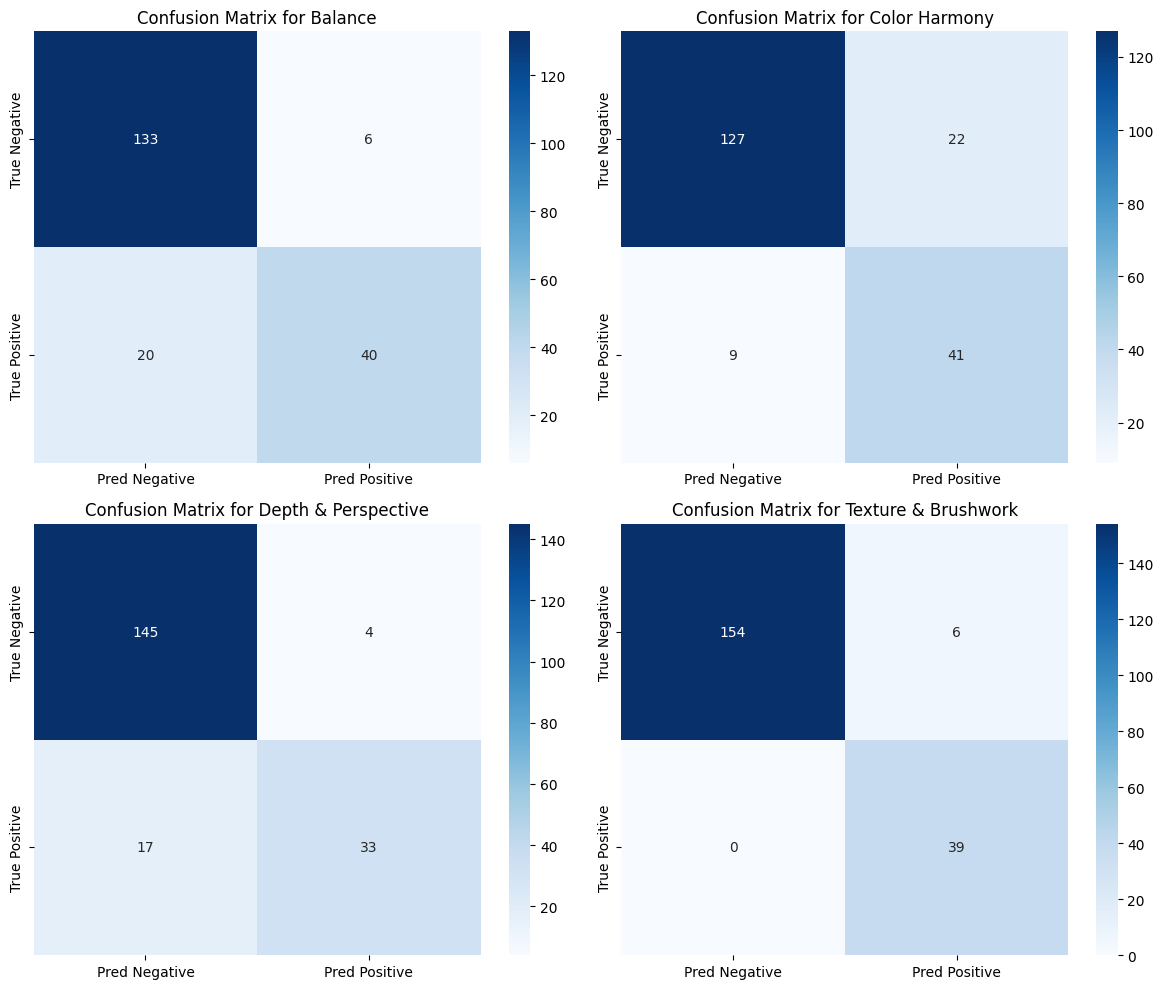

Test Accuracy: 89.45%
Precision: 76.63%
Recall: 76.88%
F1-Score: 76.72%


In [9]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
resNet101_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = resNet101_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
